# **Disciplina CAT010** - Aplicações dos Satélites em Ciências Atmosféricas


---






## **Aula Prática 1:** $\underline{Realizando\ Classificação\ de\ Nuvens}$
---
**OBJETIVO:** Nesta aula prática aprenderemos como realizar a classificação de nuvens usando dados do canal visível e infravermelho. Para isto usaremos os dados do sensor [Advanced Baseline Imager (ABI)](https://space.oscar.wmo.int/instruments/view/abi) do satélite [Geostationary Operational Environmental Satellite (GOES-16)](https://space.oscar.wmo.int/satellites/view/goes_16).

---


**DADOS DE ENTRADA**: Arquivos de temperatura de brilho dos canais **visível** e **infravermelho**

1. $\underline{Visível}$: CH02 - 0.64 µm
- **Tipo do dado:** matriz de 6262 linhas x 6262 colunas  
- **Formato do dado:** arquivo NETCDF
- **Nome do arquivo:** S10635334_202001231200.nc
- **Fonte dos dados:** FTP do [CPTEC/INPE](http://ftp.cptec.inpe.br/goes/goes16/retangular/ch02/)

    ----------

2. $\underline{Infravermelho}$: CH13 - 10.35 µm
- **Tipo do dado:** matriz de 3131 linhas x 3131 colunas  
- **Formato do dado:** arquivo NETCDF
- **Nome do arquivo:** S10635346_202001231200.nc
- **Fonte dos dados:** FTP do [CPTEC/INPE](http://ftp.cptec.inpe.br/goes/goes16/retangular/ch13/)

---

**DADOS DE SAÍDA:**
- **Tipo do dado:** Figuras
- **Formato do dado:** arquivos PNG
- **Imagens geradas:**
    1. Fig_1_vis_ir.png
    2. Fig_2_vis_ir_recorte.png
    3. Fig_3_dispersao_TxR.png

---

**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:
1.   Instalação de bibliotecas
2.   Monta o google drive
3.   Define o caminho do google drive
4.   Importação das bibliotecas
5.   Download dos shapefiles
6.   Baixa os dados de satélite
7.   Plota as imagens da **América do Sul** do visível e infravermelho em forma de painel
9.   Plota as imagens da **área de recorte** do visível e infravermelho em forma de painel
10.  Plota gráfico de dispersão de temperatura versus refletância


---
**OBSERVAÇÕES IMPORTANTES**:
1. Fazer mudanças, veja em: **### >>> MUDANÇAS AQUI <<< ###**
    - 1. Caminho do seu drive
    - 2. Escolha a data da sua imagem de satélite
    - 3. Altere os limites da área de recorte

---
- **Realizado por:** Enrique V. Mattos - 23/08/2022
- **Atualizado por:** Enrique V. Mattos - 19/09/2023


---

# **1° Passo:** Instalando as bibliotecas

In [ ]:
# Instalando o proplot (usado para gerar Mapas também)
!pip install -q proplot

# Instalando o cartopy (usado para gerar Mapas)
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical

Chegando aqui, será necessário fazer a **Reinicialização do Ambiente de Execução** (acessar *Ambiente de execução* que esta na barra de ferramentas e clicar em *Reiniciar Ambiente de Execução* e rodar novamente a célula anterior de instalações) e ter que instalar todos os pacotes de novo. Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab, então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

In [2]:
# Instalando a biblioteca Salem
!pip install -q rasterio pyproj geopandas salem descartes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.6 MB/s eta 0:00:00


# **2° Passo:** Montando drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **3° Passo:** Caminho do diretório - **### >>> MUDANÇAS AQUI <<< ###**

- Insira aqui o caminho da pasta do seu Google Drive onde esta o código dessa aula: `alterar aqui`

In [4]:
dir = '/content/drive/MyDrive/00_DISPONIBILIZAÇÃO_DE_AULAS/2_SEGUNDO_SEMESTRE/CAT010 - APLICAÇÕES DOS SATÉLITES EM CIÊNCIAS ATMOSFÉRICAS/AULAS/CAT010 - PYTHON PARA SATÉLITES METEOROLÓGICOS/AULA_02_CLASSIFICACAO_DE_NUVENS/'

- **Criando a pasta de saída ("output")**

In [5]:
# cria o diretório dos dados de saída
import os
os.makedirs(f'{dir}output', exist_ok=True)

# **4° Passo:** Importando as bibliotecas

In [42]:
import numpy as np
import proplot as pplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import glob
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import os
from tqdm.notebook import tqdm_notebook
import imageio
import xarray as xr
import pandas as pd
import salem
import time

import sys
sys.path.append(f'{dir}')
from cpt_convert import loadCPT

import warnings
warnings.filterwarnings("ignore")

# **5° Passo:** Download dos dados de shapefiles
- Utilizaremos shapefiles para plotar os contornos dos Estados brasileiros. Para isto utilizaremos os arquivos shapefiles disponibilizados no [repositório](https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/) do IBGE.

In [9]:
print('=================== BAIXANDO SHAPEFILES ===================')

# Shapefile dos todos ESTADOS brasileiros
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
!unzip -o /content/br_unidades_da_federacao.zip

# lendo shapefile de todos Estados do Brasil
estados = salem.read_shapefile('/content/BR_UF_2019.shp')
estados

=================== BAIXANDO SHAPEFILES ===================
--2023-09-19 14:58:41--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  /content/br_unidades_da_federacao.zip
 extracting: BR_UF_2019.cpg          
  inflating: BR_UF_2019.dbf          
  inflating: BR_UF_2019.prj          
  inflating: BR_UF_2019.shp          
  inflating: BR_UF_2019.shx          


,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry,min_x,max_x,min_y,max_y
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",-66.810253,-59.774357,-13.693700,-7.975868
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828...",-73.990450,-66.623754,-11.145561,-7.111824
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620...",-73.801558,-56.097558,-9.818046,2.246631
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416...",-64.825254,-58.886884,-1.580633,5.271841
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ...",-58.898328,-46.061425,-9.841153,2.591027
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2...",-54.876250,-49.875682,-1.236176,4.508817
6,17,Tocantins,TO,Norte,"POLYGON ((-48.23163 -5.94614, -48.23011 -5.938...",-50.742064,-45.699265,-13.467713,-5.168381
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.53830 -2.02124, -44.53742 ...",-48.755151,-41.795884,-10.261765,-1.049328
8,22,Piauí,PI,Nordeste,"POLYGON ((-42.91539 -6.64607, -42.91645 -6.644...",-46.028207,-40.370510,-10.928756,-2.749753
9,23,Ceará,CE,Nordeste,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017...",-41.423518,-37.252659,-7.858182,-2.784323


# **PARTE 1)**: Baixando os dados de satélite

---


- Olá pessoal. A ideia dessa aula é vocês baixarem os dados brutos de satélite direto da fonte. Assim, o primeiro passo será baixar os dados de satélite para os canais `visível` e `infravermelho` para uma determinada data.
- Esses dados são fornecidos pela NOAA e reprocessados pela [Divisão de Satélites (DSA)](http://satelite.cptec.inpe.br/home/index.jsp) do CPTEC/INPE e estão disponíveis no [ftp](http://ftp.cptec.inpe.br/goes/goes16/retangular/) do INPE. Abaixo seguem informações sobres esses 3 canais:



---

1. [Visível](http://ftp.cptec.inpe.br/goes/goes16/retangular/ch02/): CH02 - 0.64 µm
2. [Infravermelho](http://ftp.cptec.inpe.br/goes/goes16/retangular/ch13/): CH13 - 10.35 µm

---








Abaixo precisaremos definir o **ano**, **mês**, **dia**, **hora** e **minuto** do dado que gostaríamos de gerar a imagem de satélite. **Lembre-se**: os dados do sensor **ABI** do satélite **GOES-16** possui resolução temporal de 10 min. Por exemplo: 00:00, 00:10, 00:20, ... No exemplo a seguir iremos baixar e gerar a imagem do dia **1 de janeiro de 2021 às 17 horas e 0 minutos**.

In [10]:
# Defina a data/horário da imagem e o satélite
ano, mes, dia, hor, minu = '2021', '01', '01', '17', '00'

In [11]:
# Endereço do FTP do CPTEC-INPE
ftp_cptec = 'http://ftp.cptec.inpe.br/goes/'

In [12]:
# Montando os nomes dos arquivos. É o caminho onde estão os dados nop ftp do INPE.
file_vis = f'{ftp_cptec}goes16/retangular/ch02/{ano}/{mes}/S10635334_{ano}{mes}{dia}{hor}{minu}.nc'
file_ir =  f'{ftp_cptec}goes16/retangular/ch13/{ano}/{mes}/S10635346_{ano}{mes}{dia}{hor}{minu}.nc'

print(file_vis)
print(file_ir)

http://ftp.cptec.inpe.br/goes/goes16/retangular/ch02/2021/01/S10635334_202101011700.nc
http://ftp.cptec.inpe.br/goes/goes16/retangular/ch13/2021/01/S10635346_202101011700.nc


In [ ]:
# Download dos arquivos
!wget -c {file_vis}
!wget -c {file_ir}

# **PARTE 2)**: Plota imagens em forma de painel: área total
Nesta etapa plotaremos numa única figura a imagem do infravermelho e visível.

- **Leitura dos dados**

In [78]:
# leitura da imagem do infravermelho
imagem_ir = xr.open_dataset(f'/content/S10635346_{ano}{mes}{dia}{hor}{minu}.nc')

In [79]:
# leitura da imagem do visível
imagem_vis = xr.open_dataset(f'/content/S10635334_{ano}{mes}{dia}{hor}{minu}.nc')

In [80]:
# mostra os dados do canal infravermelho: temperatura
imagem_ir

<xarray.Dataset>
Dimensions:  (lat: 3131, lon: 3131)
Coordinates:
  * lat      (lat) float64 -55.99 -55.96 -55.93 -55.9 ... 34.9 34.93 34.96 34.99
  * lon      (lon) float64 -116.0 -116.0 -115.9 -115.9 ... -25.07 -25.04 -25.01
Data variables:
    Band1    (lat, lon) float64 ...
    crs      |S1 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 2.2.2, released 2017/09/15
    history:      Fri Jan 01 21:27:17 2021: GDAL Create( /dados/output/goes16...

In [81]:
# mostra os dados do canal visível: refletância
imagem_vis

<xarray.Dataset>
Dimensions:  (lat: 6262, lon: 6262)
Coordinates:
  * lat      (lat) float64 -55.99 -55.98 -55.96 -55.95 ... 34.96 34.98 34.99
  * lon      (lon) float64 -116.0 -116.0 -116.0 -115.9 ... -25.04 -25.02 -25.01
Data variables:
    Band1    (lat, lon) float64 ...
    crs      |S1 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 2.2.2, released 2017/09/15
    history:      Sat Jan 02 01:38:04 2021: GDAL Create( /dados/output/goes16...

- **Organiza os dados**

In [82]:
imagem_ir['Band1'].values

array([[26353., 26353., 26390., ..., 23126., 23071., 23071.],
       [26439., 26439., 26353., ..., 23243., 23108., 23108.],
       [26599., 26525., 26525., ..., 23108., 23090., 23090.],
       ...,
       [27877., 28080., 28239., ..., 26863., 26857., 27072.],
       [28123., 28153., 28209., ..., 26746., 26918., 26826.],
       [28233., 28233., 28153., ..., 26949., 26949., 26980.]])

Os dados do infravermelho estão no formato de temperatura de brilho.

In [83]:
# divide os dados do infravermelho por 100 e transforma os dados de Kelvin para Celsius
imagem_ir = (imagem_ir['Band1']/100.)-273.15

Os dados do visível estão no formato de refletância.

In [84]:
# divide os dados do visível por 100
imagem_vis = (imagem_vis['Band1']/100.)

- **Define o limite geral da imagem e do recorte**

In [85]:
# limites da imagem geral
lonmin, lonmax, latmin, latmax = float(imagem_ir['lon'][0]), float(imagem_ir['lon'][-1]), float(imagem_ir['lat'][0]), float(imagem_ir['lat'][-1])

In [86]:
# limites da área de recorte
lonmin_rec, lonmax_rec, latmin_rec, latmax_rec = -40, -35, -30, -25

- **Plota imagem**

In [87]:
%%time
#=================================================================================#
#                           DEFINIÇÕES DO GRÁFICO
#=================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(ncols=2, nrows=1, figsize=(11.5,5), proj='pcarree', tight=True)

# formatação dos eixos
ax.format(coast=True, borders=True, innerborders=False,
          labels=False,
          latlines=20, lonlines=20,
          latlim=(latmin, latmax),
          lonlim=(lonmin, lonmax),
          suptitle=f'GOES-16: {ano}-{mes}-{dia} às {hor}{minu} UTC',
          abc=True, abcstyle='a)', abcsize=5, abcloc = 'ul',
          small='20px', large='25px')

# define qual eixo terá os labels de latitudes e longitudes
ax[0].format(labels = [True, False, True, False])
ax[1].format(labels = [False, False, True, False])

#=================================================================================#
#                        FIGURA A): VISÍVEL
#=================================================================================#
# plota mapa
map1 = ax[0].imshow(np.flipud(imagem_vis),
             cmap='Greys_r',
             extent=[lonmin, lonmax, latmin, latmax],
             levels=pplt.arange(0, 100, 1.0))

# plota quadrado na figura
ax[0].fill_between((lonmin_rec, lonmax_rec), *(latmin_rec, latmax_rec), zorder=3, edgecolor='red', facecolor=plot.set_alpha('red', 0.3))

# plota contornos dos Estados
estados.plot(edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.8, ax=ax[0])

# plota titulo de cada figura
ax[0].format(title='VIS: CH02 (0.64 µm)', linewidth=1)

# plota barra de cores da figura
ax[0].colorbar(map1, loc='r', label='Refletância (%)', ticks=25, ticklabelsize=13, labelsize=15, length=0.99, space=-8.0)

#=================================================================================#
#                        FIGURA B): INFRAVERMELHO
#=================================================================================#
# Carrega tabela de cores
cpt_ir = loadCPT(f'{dir}ir.cpt')
cmap_ir = cm.colors.LinearSegmentedColormap('cpt_ir', cpt_ir)

# plota mapa
map2 =  ax[1].imshow(np.flipud(imagem_ir),
                    cmap=cmap_ir,
                    extent=[lonmin, lonmax, latmin, latmax],
                    levels=pplt.arange(-103.0, 105, 1.0))

# plota quadrado na figura
ax[1].fill_between((lonmin_rec, lonmax_rec), *(latmin_rec, latmax_rec), zorder=3, edgecolor='red', facecolor=plot.set_alpha('red', 0.3))

# plota contornos dos Estados
estados.plot(edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.8, ax=ax[1])

# plota titulo de cada figura
ax[1].format(title='IR: CH13 (10.35 µm)', linewidth=1)

# plota barra de cores da figura
ax[1].colorbar(map2, loc='r', label='Temperatura ($\degree$C)', ticks=25, ticklabelsize=13, labelsize=15, length=0.99, space=-8.0)

#=================================================================================#
#                            SALVA FIGURA
#=================================================================================#
# salva figura
fig.savefig(f'{dir}output/Fig_1_vis_ir.jpg', dpi=300)

# exibe a figura na tela
pplt.show()

Output hidden; open in https://colab.research.google.com to view.

# **PARTE 3)**: Plota imagens em forma de painel: área do recorte

- **Recorta as imagens**

In [66]:
# lembrando a região da imagem de satélite que iremos focar na nossa análise
print('#-------------------- Limites de longitude --------------------#')
print('longitude miníma=', lonmin_rec)
print('longitude máxima=', lonmax_rec, '\n')

print('#-------------------- Limites de latitude --------------------#')
print('latitude mínima=', latmin_rec)
print('latitude máxima=', latmax_rec)

#-------------------- Limites de longitude --------------------#
longitude miníma= -40
longitude máxima= -35 

#-------------------- Limites de latitude --------------------#
latitude mínima= -30
latitude máxima= -25


In [67]:
# faz o recorte na imagem do infravermelho
imagem_ir_rec = imagem_ir.sel(lon=slice(lonmin_rec, lonmax_rec), lat=slice(latmin_rec, latmax_rec))

In [68]:
# mostra os dados recortados do infravermelho
imagem_ir_rec

<xarray.DataArray 'Band1' (lat: 172, lon: 172)>
array([[-37.15, -37.15, -37.95, ..., -32.36, -29.1 , -32.67],
       [-34.08, -32.54, -37.95, ..., -26.21, -24.25, -23.33],
       [-30.33, -28.43, -28.43, ..., -35.43, -30.27, -24.25],
       ...,
       [  0.39,   8.88,  12.44, ...,   2.18,   1.56,   5.74],
       [  5.86,  12.26,   8.94, ...,   3.71,   5.31,   6.42],
       [  4.02,  10.1 ,   6.85, ...,   6.48,   6.91,  10.6 ]])
Coordinates:
  * lat      (lat) float64 -29.97 -29.94 -29.91 -29.89 ... -25.06 -25.03 -25.0
  * lon      (lon) float64 -39.98 -39.95 -39.92 -39.9 ... -35.07 -35.04 -35.01

In [69]:
# faz o recorte na imagem do visível
imagem_vis_rec = imagem_vis.sel(lon=slice(lonmin_rec, lonmax_rec), lat=slice(latmin_rec, latmax_rec))

In [70]:
# mostra os dados recortados do visível
imagem_ir_rec

<xarray.DataArray 'Band1' (lat: 172, lon: 172)>
array([[-37.15, -37.15, -37.95, ..., -32.36, -29.1 , -32.67],
       [-34.08, -32.54, -37.95, ..., -26.21, -24.25, -23.33],
       [-30.33, -28.43, -28.43, ..., -35.43, -30.27, -24.25],
       ...,
       [  0.39,   8.88,  12.44, ...,   2.18,   1.56,   5.74],
       [  5.86,  12.26,   8.94, ...,   3.71,   5.31,   6.42],
       [  4.02,  10.1 ,   6.85, ...,   6.48,   6.91,  10.6 ]])
Coordinates:
  * lat      (lat) float64 -29.97 -29.94 -29.91 -29.89 ... -25.06 -25.03 -25.0
  * lon      (lon) float64 -39.98 -39.95 -39.92 -39.9 ... -35.07 -35.04 -35.01

- **Plota a figura**

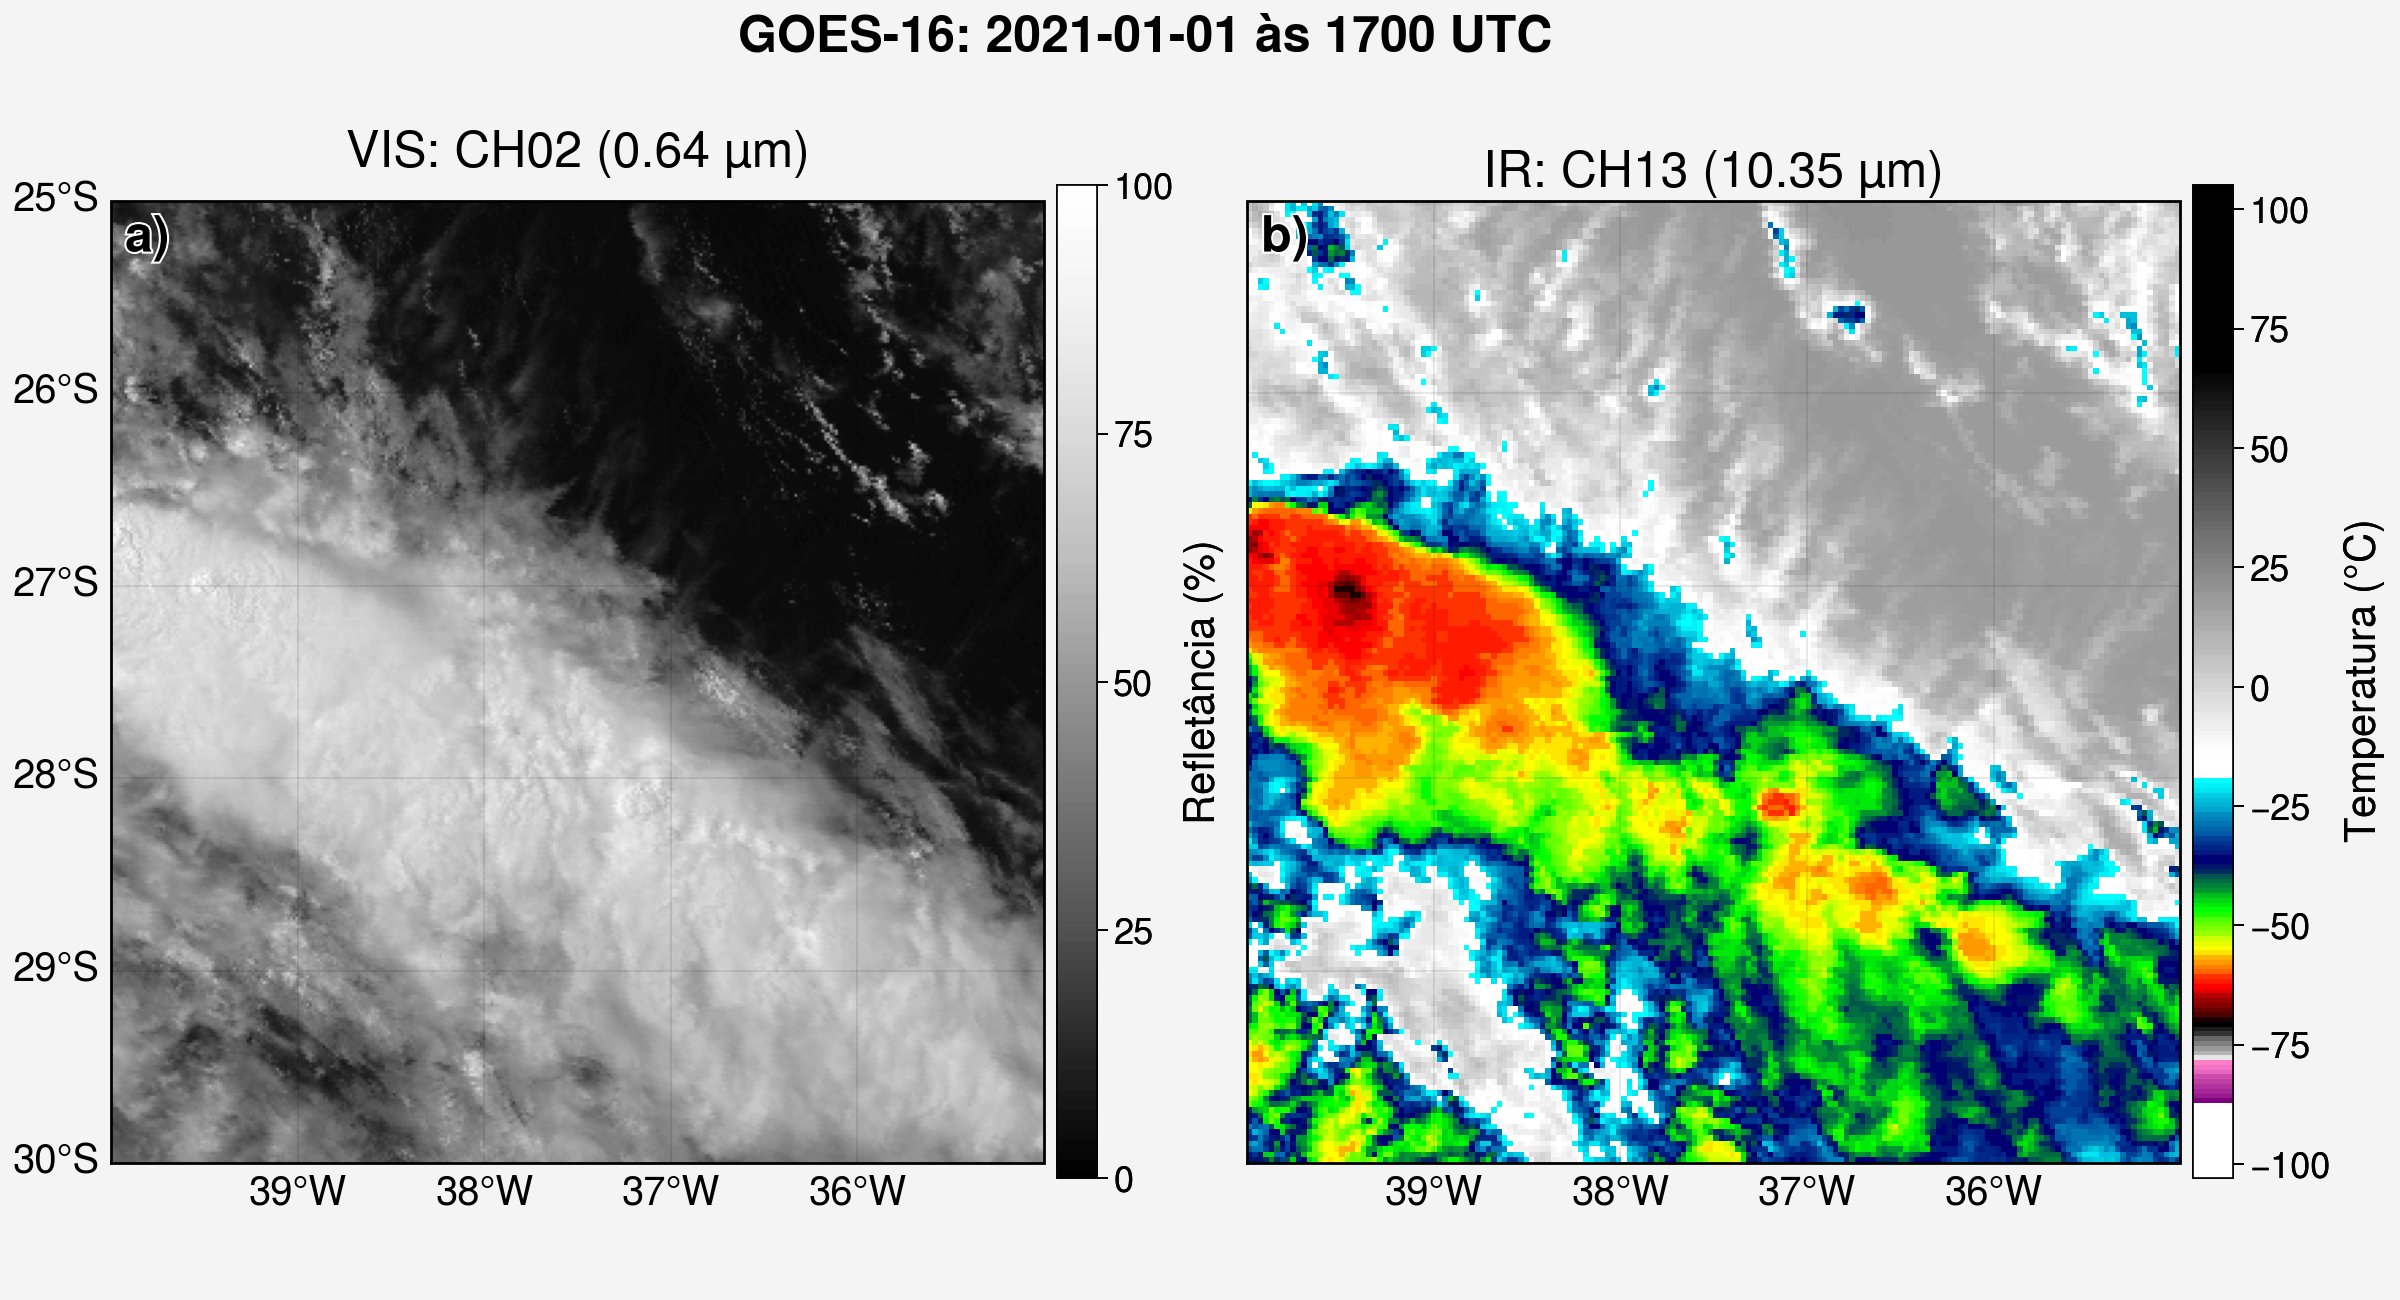

CPU times: user 6.26 s, sys: 1.58 s, total: 7.84 s
Wall time: 6.2 s


In [89]:
%%time
#=================================================================================#
#                           DEFINIÇÕES DO GRÁFICO
#=================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(ncols=2, nrows=1, figsize=(12,6.5), proj='pcarree', tight=True)

# formatação dos eixos
ax.format(coast=True, borders=True, innerborders=False,
          labels=False,
          latlim=(latmin_rec, latmax_rec),
          lonlim=(lonmin_rec, lonmax_rec),
          suptitle=f'GOES-16: {ano}-{mes}-{dia} às {hor}{minu} UTC',
          abc=True, abcstyle='a)', abcsize=5, abcloc = 'ul',
          small='20px', large='25px')

# define qual eixo terá os labels de latitudes e longitudes
ax[0].format(labels = [True, False, True, False])
ax[1].format(labels = [False, False, True, False])

#=================================================================================#
#                        FIGURA A): VISÍVEL
#=================================================================================#
# plota mapa
map1 = ax[0].imshow(np.flipud(imagem_vis_rec),
             cmap='Greys_r',
             extent=[lonmin_rec, lonmax_rec, latmin_rec, latmax_rec],
             levels=pplt.arange(0, 100, 1.0))

# plota contornos dos Estados
estados.plot(edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.8, ax=ax[0])

# plota titulo de cada figura
ax[0].format(title='VIS: CH02 (0.64 µm)', linewidth=1)

# plota barra de cores da figura
ax[0].colorbar(map1, loc='r', label='Refletância (%)', ticks=25, ticklabelsize=13, labelsize=15, length=0.82)

#=================================================================================#
#                        FIGURA B): INFRAVERMELHO
#=================================================================================#
# carrega tabela de cores
cpt_ir = loadCPT(f'{dir}ir.cpt')
cmap_ir = cm.colors.LinearSegmentedColormap('cpt_ir', cpt_ir)

# plota mapa
map2 =  ax[1].imshow(np.flipud(imagem_ir_rec),
                     cmap=cmap_ir,
                     extent=[lonmin_rec, lonmax_rec, latmin_rec, latmax_rec],
                     levels=pplt.arange(-103.0, 105, 1.0))

# plota contornos dos Estados
estados.plot(edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.8, ax=ax[1])

# plota titulo de cada figura
ax[1].format(title='IR: CH13 (10.35 µm)', linewidth=1)

# plota barra de cores da figura
ax[1].colorbar(map2, loc='r', label='Temperatura ($\degree$C)', ticks=25, ticklabelsize=13, labelsize=15, length=0.82)

#=================================================================================#
#                            SALVA FIGURA
#=================================================================================#
# salva figura
fig.savefig(f'{dir}output/Fig_2_vis_ir_recorte.jpg', dpi=300)

# exibe a figura na tela
pplt.show()

# **PARTE 4)**: Plota gráfico de dispersão **Temperatura** versus **Refletância**

- **Faz a interpolação do canal visível**

In [138]:
# mostrando a quantidade de linhas e colunas da matriz de "refletância"
imagem_vis_rec.shape

(344, 344)

In [139]:
# mostrando a quantidade de linhas e colunas da matriz de "temperatura"
imagem_ir_rec.shape

(172, 172)

- Como queremos extrair o par de valores de **temperatura**-**refletância** pertencente a cada pixel, precisaremos antes colocar as matrizes de temperatura e refletância numa grade com a mesma resolução espacial.
- Para isto pegaremos a grade de refletância que possui 500 m e transformaremos numa grade de 2 km de resolução espacial.
- O [Xarray](https://docs.xarray.dev/en/stable/index.html) tem uma função chamada [**interp**](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html) que realiza o processo de interpolação de dados. Nessa função precisaremos informar as **latitudes e longitudes da nova grade** e o **método de interpolação**.

In [140]:
# consultando informações sobre a função "interp" do xarray
xr.DataArray.interp?

In [141]:
# faz a interpolação dos dados do visivel de 0.5 km para 2 km
imagem_vis_rec_new = imagem_vis_rec.interp(lat=imagem_ir_rec['lat'], lon=imagem_ir_rec['lon'], method='linear')

In [142]:
# mostra a matriz de latitude do visível que foi interpolada
imagem_vis_rec_new['lat']

<xarray.DataArray 'lat' (lat: 172)>
array([-29.973012, -29.943948, -29.914883, -29.885819, -29.856755, -29.827691,
       -29.798627, -29.769562, -29.740498, -29.711434, -29.68237 , -29.653306,
       -29.624241, -29.595177, -29.566113, -29.537049, -29.507985, -29.47892 ,
       -29.449856, -29.420792, -29.391728, -29.362664, -29.333599, -29.304535,
       -29.275471, -29.246407, -29.217343, -29.188279, -29.159214, -29.13015 ,
       -29.101086, -29.072022, -29.042958, -29.013893, -28.984829, -28.955765,
       -28.926701, -28.897637, -28.868572, -28.839508, -28.810444, -28.78138 ,
       -28.752316, -28.723251, -28.694187, -28.665123, -28.636059, -28.606995,
       -28.57793 , -28.548866, -28.519802, -28.490738, -28.461674, -28.432609,
       -28.403545, -28.374481, -28.345417, -28.316353, -28.287288, -28.258224,
       -28.22916 , -28.200096, -28.171032, -28.141967, -28.112903, -28.083839,
       -28.054775, -28.025711, -27.996646, -27.967582, -27.938518, -27.909454,
       -27.88039 , -27.851325, -27.822261, -27.793197, -27.764133, -27.735069,
       -27.706004, -27.67694 , -27.647876, -27.618812, -27.589748, -27.560683,
       -27.531619, -27.502555, -27.473491, -27.444427, -27.415363, -27.386298,
       -27.357234, -27.32817 , -27.299106, -27.270042, -27.240977, -27.211913,
       -27.182849, -27.153785, -27.124721, -27.095656, -27.066592, -27.037528,
       -27.008464, -26.9794  , -26.950335, -26.921271, -26.892207, -26.863143,
       -26.834079, -26.805014, -26.77595 , -26.746886, -26.717822, -26.688758,
       -26.659693, -26.630629, -26.601565, -26.572501, -26.543437, -26.514372,
       -26.485308, -26.456244, -26.42718 , -26.398116, -26.369051, -26.339987,
       -26.310923, -26.281859, -26.252795, -26.22373 , -26.194666, -26.165602,
       -26.136538, -26.107474, -26.078409, -26.049345, -26.020281, -25.991217,
       -25.962153, -25.933088, -25.904024, -25.87496 , -25.845896, -25.816832,
       -25.787767, -25.758703, -25.729639, -25.700575, -25.671511, -25.642447,
       -25.613382, -25.584318, -25.555254, -25.52619 , -25.497126, -25.468061,
       -25.438997, -25.409933, -25.380869, -25.351805, -25.32274 , -25.293676,
       -25.264612, -25.235548, -25.206484, -25.177419, -25.148355, -25.119291,
       -25.090227, -25.061163, -25.032098, -25.003034])
Coordinates:
  * lat      (lat) float64 -29.97 -29.94 -29.91 -29.89 ... -25.06 -25.03 -25.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north

In [143]:
# mostra a matriz de latitude do infravermelho
imagem_ir_rec['lat']

<xarray.DataArray 'lat' (lat: 172)>
array([-29.973012, -29.943948, -29.914883, -29.885819, -29.856755, -29.827691,
       -29.798627, -29.769562, -29.740498, -29.711434, -29.68237 , -29.653306,
       -29.624241, -29.595177, -29.566113, -29.537049, -29.507985, -29.47892 ,
       -29.449856, -29.420792, -29.391728, -29.362664, -29.333599, -29.304535,
       -29.275471, -29.246407, -29.217343, -29.188279, -29.159214, -29.13015 ,
       -29.101086, -29.072022, -29.042958, -29.013893, -28.984829, -28.955765,
       -28.926701, -28.897637, -28.868572, -28.839508, -28.810444, -28.78138 ,
       -28.752316, -28.723251, -28.694187, -28.665123, -28.636059, -28.606995,
       -28.57793 , -28.548866, -28.519802, -28.490738, -28.461674, -28.432609,
       -28.403545, -28.374481, -28.345417, -28.316353, -28.287288, -28.258224,
       -28.22916 , -28.200096, -28.171032, -28.141967, -28.112903, -28.083839,
       -28.054775, -28.025711, -27.996646, -27.967582, -27.938518, -27.909454,
       -27.88039 , -27.851325, -27.822261, -27.793197, -27.764133, -27.735069,
       -27.706004, -27.67694 , -27.647876, -27.618812, -27.589748, -27.560683,
       -27.531619, -27.502555, -27.473491, -27.444427, -27.415363, -27.386298,
       -27.357234, -27.32817 , -27.299106, -27.270042, -27.240977, -27.211913,
       -27.182849, -27.153785, -27.124721, -27.095656, -27.066592, -27.037528,
       -27.008464, -26.9794  , -26.950335, -26.921271, -26.892207, -26.863143,
       -26.834079, -26.805014, -26.77595 , -26.746886, -26.717822, -26.688758,
       -26.659693, -26.630629, -26.601565, -26.572501, -26.543437, -26.514372,
       -26.485308, -26.456244, -26.42718 , -26.398116, -26.369051, -26.339987,
       -26.310923, -26.281859, -26.252795, -26.22373 , -26.194666, -26.165602,
       -26.136538, -26.107474, -26.078409, -26.049345, -26.020281, -25.991217,
       -25.962153, -25.933088, -25.904024, -25.87496 , -25.845896, -25.816832,
       -25.787767, -25.758703, -25.729639, -25.700575, -25.671511, -25.642447,
       -25.613382, -25.584318, -25.555254, -25.52619 , -25.497126, -25.468061,
       -25.438997, -25.409933, -25.380869, -25.351805, -25.32274 , -25.293676,
       -25.264612, -25.235548, -25.206484, -25.177419, -25.148355, -25.119291,
       -25.090227, -25.061163, -25.032098, -25.003034])
Coordinates:
  * lat      (lat) float64 -29.97 -29.94 -29.91 -29.89 ... -25.06 -25.03 -25.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north

Note que agora a matriz de latitude/longitude do visível e infravermelho são iguais.


In [144]:
print(imagem_vis_rec_new.shape)
print(imagem_ir_rec.shape)

(172, 172)
(172, 172)


Note também que os valores iniciais e finais das matrizes do visível e infravermelho são iguais.

In [145]:
# imprime na tela os valores mínimos e máximos das matrizes de "latitude" do visível interpolada e do infravermelho
print( float(imagem_vis_rec_new['lat'][0]), float(imagem_ir_rec['lat'][0]) )
print( float(imagem_vis_rec_new['lat'][-1]), float(imagem_ir_rec['lat'][-1]) )

-29.973011817310766 -29.973011817310766
-25.00303417438518 -25.00303417438518


In [146]:
# imprime na tela os valores mínimos e máximos das matrizes de "longitude" do visível interpolada e do infravermelho
print( float(imagem_vis_rec_new['lon'][0]), float(imagem_ir_rec['lon'][0]) )
print( float(imagem_vis_rec_new['lon'][-1]), float(imagem_ir_rec['lon'][-1]) )

-39.982593420632384 -39.982593420632384
-35.01261577770681 -35.01261577770681


- **Gera a tabela com os dados**.
Para facilitar a comparação entre os dados de temperatura e refletância vamos colocar os dados da matriz do visível (`imagem_vis_rec_new`) e infravermelho (`imagem_ir_rec`) numa tabela (dataframe), usando o comando [*to_dataframe*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) do **pandas**.

In [147]:
# insere os dados da matriz de refletância numa tabela
df_vis = imagem_vis_rec_new.to_dataframe().reset_index()
df_vis

,lat,lon,Band1
0,-29.973012,-39.982593,32.2500
1,-29.973012,-39.953529,31.4975
2,-29.973012,-39.924465,30.4875
3,-29.973012,-39.895401,30.9925
4,-29.973012,-39.866337,33.4075
...,...,...,...
29579,-25.003034,-35.128873,NaN
29580,-25.003034,-35.099808,NaN
29581,-25.003034,-35.070744,NaN
29582,-25.003034,-35.041680,NaN


In [148]:
# renomeia o nome da coluna de "Band1" para "refletância"
df_vis.rename(columns={'Band1':'refletancia'}, inplace=True)
df_vis

,lat,lon,refletancia
0,-29.973012,-39.982593,32.2500
1,-29.973012,-39.953529,31.4975
2,-29.973012,-39.924465,30.4875
3,-29.973012,-39.895401,30.9925
4,-29.973012,-39.866337,33.4075
...,...,...,...
29579,-25.003034,-35.128873,NaN
29580,-25.003034,-35.099808,NaN
29581,-25.003034,-35.070744,NaN
29582,-25.003034,-35.041680,NaN


In [149]:
# elimina as colunas "lat" e "lon" da tabela de refletância
#df_vis.drop(columns=(['lat', 'lon']), inplace=True)
#df_vis

In [150]:
# insere os dados da matriz de temperatura numa tabela
df_ir = imagem_ir_rec.to_dataframe().reset_index()
df_ir

,lat,lon,Band1
0,-29.973012,-39.982593,-37.15
1,-29.973012,-39.953529,-37.15
2,-29.973012,-39.924465,-37.95
3,-29.973012,-39.895401,-38.26
4,-29.973012,-39.866337,-41.70
...,...,...,...
29579,-25.003034,-35.128873,-3.17
29580,-25.003034,-35.099808,1.50
29581,-25.003034,-35.070744,6.48
29582,-25.003034,-35.041680,6.91


In [151]:
# renomeia o nome da coluna de "Band1" para "temperatura"
df_ir.rename(columns={'Band1':'temperatura'}, inplace=True)
df_ir

,lat,lon,temperatura
0,-29.973012,-39.982593,-37.15
1,-29.973012,-39.953529,-37.15
2,-29.973012,-39.924465,-37.95
3,-29.973012,-39.895401,-38.26
4,-29.973012,-39.866337,-41.70
...,...,...,...
29579,-25.003034,-35.128873,-3.17
29580,-25.003034,-35.099808,1.50
29581,-25.003034,-35.070744,6.48
29582,-25.003034,-35.041680,6.91


In [173]:
# junta as tabelas
df = pd.concat([df_vis, df_ir], axis=1)
df

,lat,lon,refletancia,lat,lon,temperatura
0,-29.973012,-39.982593,32.2500,-29.973012,-39.982593,-37.15
1,-29.973012,-39.953529,31.4975,-29.973012,-39.953529,-37.15
2,-29.973012,-39.924465,30.4875,-29.973012,-39.924465,-37.95
3,-29.973012,-39.895401,30.9925,-29.973012,-39.895401,-38.26
4,-29.973012,-39.866337,33.4075,-29.973012,-39.866337,-41.70
...,...,...,...,...,...,...
29579,-25.003034,-35.128873,NaN,-25.003034,-35.128873,-3.17
29580,-25.003034,-35.099808,NaN,-25.003034,-35.099808,1.50
29581,-25.003034,-35.070744,NaN,-25.003034,-35.070744,6.48
29582,-25.003034,-35.041680,NaN,-25.003034,-35.041680,6.91


In [174]:
# elimina as colunas "lat" e "lon" da tabela de refletância
df.drop(columns=(['lat', 'lon']), inplace=True)
df

,refletancia,temperatura
0,32.2500,-37.15
1,31.4975,-37.15
2,30.4875,-37.95
3,30.9925,-38.26
4,33.4075,-41.70
...,...,...
29579,NaN,-3.17
29580,NaN,1.50
29581,NaN,6.48
29582,NaN,6.91


In [175]:
# elimina (drop) as linhas que tenham "NaN"
df.dropna(inplace=True)
df

,refletancia,temperatura
0,32.2500,-37.15
1,31.4975,-37.15
2,30.4875,-37.95
3,30.9925,-38.26
4,33.4075,-41.70
...,...,...
29407,11.7575,-5.50
29408,10.8425,-1.94
29409,8.9000,3.71
29410,9.1925,5.31


- **Plota a figura**

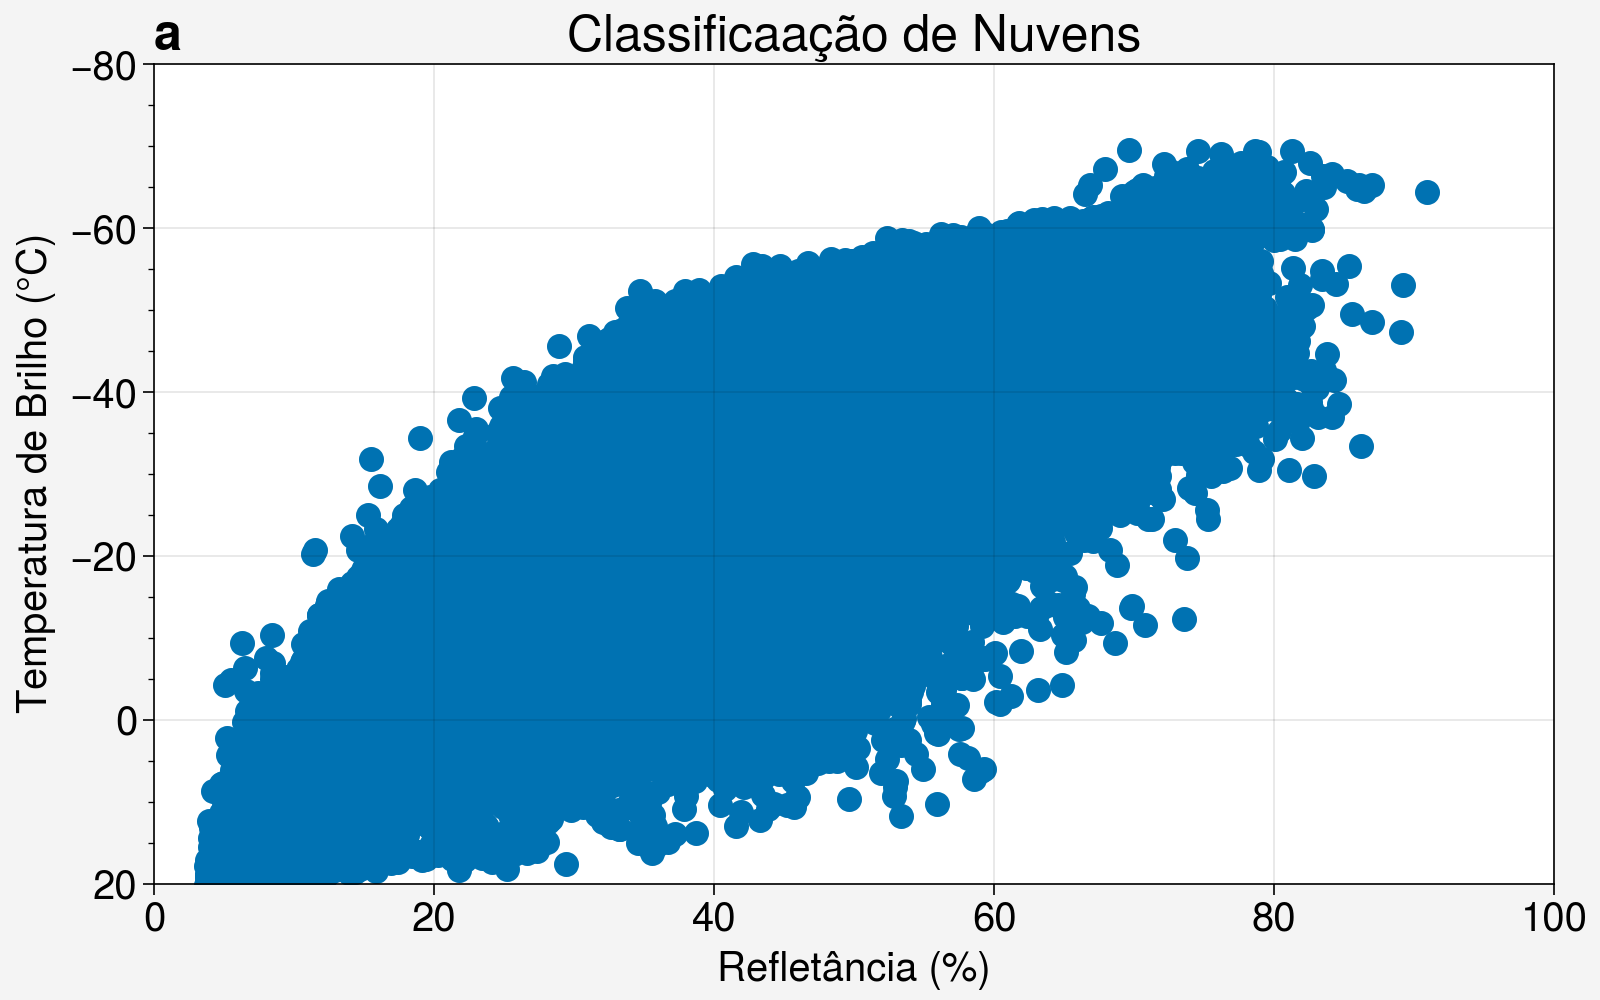

In [176]:
# cria a moldura da figura
fig, ax = pplt.subplots(figsize=(8,5), tight=True)

# plota gráfico de linha
ax.scatter(df['refletancia'].values,
           df['temperatura'].values,
           lw=3,
           marker='o',
           label='pixel')

# formatação de eixos etc
ax.format(xlabel='Refletância (%)',
          ylabel='Temperatura de Brilho ($\degree$C)',
          title='Classificaação de Nuvens',
          xtickminor=False,
          ytickminor=True,
          small='20px', large='25px',
          ylim=(20,-80), xlim=(0,100))

# salva figura
fig.save(f'{dir}output/Fig_3_dispersao_TxR.jpg', dpi=300, bbox_inches='tight')

# exibe na tela
pplt.show()

Como exercício iremos comparar a imagem gerada acima com os dados reais, e a imagem de referência abaixo. Comparando ambas imagens indique quais os tipos de nuvens que existem.

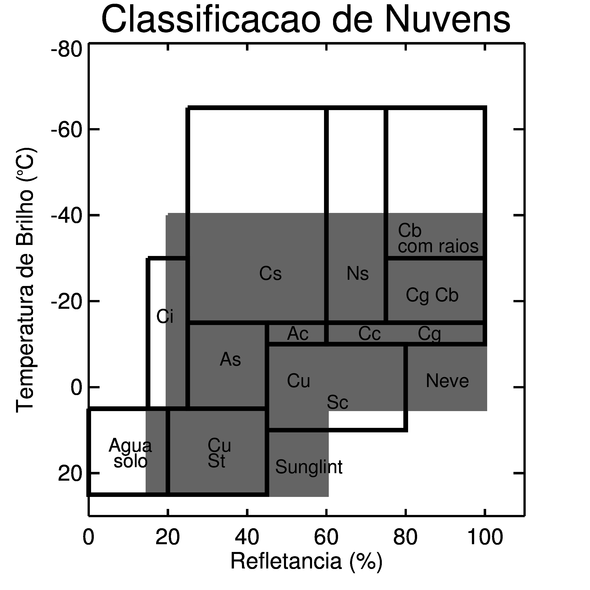